### 数据集描述：
选用Wine Reviews数据集进行关联规则挖掘：
整个数据有13列 其中 index，points，price为数值属性，其余为标称属性
其中每一种属性代表的意义如下：

1. country:来自哪个国家
2. description：品酒师对其的描述
3. designation：酿酒用的葡萄来自哪个葡萄庄园
4. points：品酒师对其的打分
5. price：一瓶酒的价格
6. province：来自哪个省份或者州
7. region_1：省内的具体地区
8. region_2：有时候存在着更具体的地址
9. taster_name： 品酒师的姓名
10. taster_twitter_handle： 品酒师的推特账号
11. title： 评论的标题
12. variety:用于酿酒的葡萄种类
13. winery：酿酒厂的名字

### 1. 对数据集进行处理，转换成适合进行关联规则挖掘的形式

In [2]:
from numpy import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

df = pd.read_csv('winemag-data-130k-v2.csv')
# 将未命名的第一列重命名为 index
df.rename(columns={'Unnamed: 0':'index'}, inplace=True)

#展示数据的格式
df.head(2)

,index,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [3]:
#保留 国家 葡萄种类  酿酒厂 得分四个属性
df = df[['country','variety','winery','points']]
#去除空值
df = df.dropna(axis=0, how='any')
df.head(5)

,country,variety,winery,points
0,Italy,White Blend,Nicosia,87
1,Portugal,Portuguese Red,Quinta dos Avidagos,87
2,US,Pinot Gris,Rainstorm,87
3,US,Riesling,St. Julian,87
4,US,Pinot Noir,Sweet Cheeks,87


In [4]:
#查看得分的数据分布情况
df['points'].describe()

count    129907.000000
mean         88.447051
std           3.040078
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [5]:
#得分的最低分为80分，最高分为100分
#因此可以将得分[95,100]划分为A,[90,95)划分为B,[85,90)划分为C,[80,85)划分为D
def points2ABCD(x):
    if x < 85:
        return 'D';
    elif x < 90:
        return 'C';
    elif x < 95:
        return 'B';
    else:
        return 'A';
df['points'] = df['points'].map(points2ABCD)
df.head(5)

,country,variety,winery,points
0,Italy,White Blend,Nicosia,C
1,Portugal,Portuguese Red,Quinta dos Avidagos,C
2,US,Pinot Gris,Rainstorm,C
3,US,Riesling,St. Julian,C
4,US,Pinot Noir,Sweet Cheeks,C


In [6]:
#将DataFram数据转换成list便于关联规则挖掘
ds = df.values.tolist()
print("Transaction Size: "+ str(len(ds)) +"\n")
print("Transaction example :"+ str(ds[100]) +"\n")

Transaction Size: 129907

Transaction example :['US', 'Pinot Gris', 'Ventosa', 'C']



### 2. 找出频繁模式

In [12]:
# 获取候选1项集，dataSet为事务集。返回一个list，每个元素都是set集合
def createC1(dataSet):
    C1 = []   # 元素个数为1的项集（非频繁项集，因为还没有同最小支持度比较）
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
    C1.sort()  # 这里排序是为了，生成新的候选集时可以直接认为两个n项候选集前面的部分相同
    # 因为除了候选1项集外其他的候选n项集都是以二维列表的形式存在，所以要将候选1项集的每一个元素都转化为一个单独的集合。
    return list(map(frozenset, C1))   #map(frozenset, C1)的语义是将C1由Python列表转换为不变集合（frozenset，Python中的数据结构）

# 找出候选集中的频繁项集
# dataSet为全部数据集，Ck为大小为k（包含k个元素）的候选项集，minSupport为设定的最小支持度
def scanD(dataSet, Ck, minSupport):
    ssCnt = {}   # 记录每个候选项的个数
    for tid in dataSet:
        for can in Ck:
            if can.issubset(tid):
                ssCnt[can] = ssCnt.get(can, 0) + 1   # 计算每一个项集出现的频率
    numItems = float(len(dataSet))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key] / numItems
        if support >= minSupport:
            retList.insert(0, key)  #将频繁项集插入返回列表的首部
        supportData[key] = support
    return retList, supportData   #retList为在Ck中找出的频繁项集（支持度大于minSupport的），supportData记录各频繁项集的支持度

# 通过频繁项集列表Lk和项集个数k生成候选项集C(k+1)。
def aprioriGen(Lk, k):
    retList = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(i + 1, lenLk):
            # 前k-1项相同时，才将两个集合合并，合并后才能生成k+1项
            L1 = list(Lk[i])[:k-2]; L2 = list(Lk[j])[:k-2]   # 取出两个集合的前k-1个元素
            L1.sort(); L2.sort()
            if L1 == L2:
                retList.append(Lk[i] | Lk[j])
    return retList

# 获取事务集中的所有的频繁项集
# Ck表示项数为k的候选项集，最初的C1通过createC1()函数生成。Lk表示项数为k的频繁项集，supK为其支持度，Lk和supK由scanD()函数通过Ck计算而来。
def apriori(dataSet, minSupport=0.5):
    C1 = createC1(dataSet)  # 从事务集中获取候选1项集
    D = list(map(set, dataSet))  # 将事务集的每个元素转化为集合
    L1, supportData = scanD(D, C1, minSupport)  # 获取频繁1项集和对应的支持度
    L = [L1]  # L用来存储所有的频繁项集
    k = 2
    while (len(L[k-2]) > 0): # 一直迭代到项集数目过大而在事务集中不存在这种n项集
        Ck = aprioriGen(L[k-2], k)   # 根据频繁项集生成新的候选项集。Ck表示项数为k的候选项集
        Lk, supK = scanD(D, Ck, minSupport)  # Lk表示项数为k的频繁项集，supK为其支持度
        L.append(Lk);supportData.update(supK)  # 添加新频繁项集和他们的支持度
        k += 1
    return L, supportData

L,suppData=apriori(ds,0.05)
#print ('C1:',C1)
# print 'L:',L
# print 'suppData:',suppData
for i in range(len(L)):
    if len(L[i])>0:
        print("频繁"+str(i+1)+"项集为:\n")
        for frequentSet in L[i]:
            print(str(frequentSet)+'\n')

频繁1项集为:

frozenset({'D'})

frozenset({'B'})

frozenset({'Bordeaux-style Red Blend'})

frozenset({'Red Blend'})

frozenset({'Chardonnay'})

frozenset({'Cabernet Sauvignon'})

frozenset({'France'})

frozenset({'Spain'})

frozenset({'Pinot Noir'})

frozenset({'US'})

frozenset({'Italy'})

frozenset({'C'})

频繁2项集为:

frozenset({'US', 'B'})

frozenset({'France', 'B'})

frozenset({'US', 'Chardonnay'})

frozenset({'US', 'Cabernet Sauvignon'})

frozenset({'France', 'C'})

frozenset({'US', 'Pinot Noir'})

frozenset({'US', 'C'})

frozenset({'C', 'Italy'})



### 3. 导出关联规则，计算其支持度和置信度;

In [76]:
#生成关联规则
def generateRules(L, supportData, minConf=0.7):  #supportData is a dict coming from scanD
    bigRuleList = []
    for i in range(1, len(L)):#only get the sets with two or more items
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            #print 'H1:',H1
            if (i > 1):
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)
    return bigRuleList         

def calcConf(freqSet, H, supportData, brl, minConf=0.7):
    prunedH = [] 
    for conseq in H:
        conf = supportData[freqSet]/supportData[freqSet-conseq] #calc confidence
        if conf >= minConf: 
            print (freqSet-conseq,'-->',conseq,'置信度:',conf,'支持度:',supportData[freqSet])
            brl.append([freqSet-conseq, conseq, conf,supportData[freqSet]])
            prunedH.append(conseq)

    return prunedH

#rulesFromConseq目的就是对每一个频繁项集生成右边的规则，一个频繁项集可以生成很多右边的规则
#if (len(freqSet) > (m + 1))这是迭代停止的条件，也就是当右边的规则的元素数+1=该频繁项长度时停止迭代
#if (len(Hmp1) > 1)当Hmp1的长度大于1时才能合并，合并需要至少两个frozenset
def rulesFromConseq(freqSet, H, supportData, brl, minConf=0.7):
    m = len(H[0])
    #print'm:',m
   # print'len(freqSet):',len(freqSet)
    if (len(freqSet) > (m + 1)): #try further merging
        Hmp1 = aprioriGen(H, m+1)#create Hm+1 new candidates
        #print'Hmp1:',Hmp1
        Hmp1 = calcConf(freqSet, Hmp1, supportData, brl, minConf)
        #print 'Hmp2:',Hmp1
        if (len(Hmp1) > 1):    #need at least two sets to merge
            rulesFromConseq(freqSet, Hmp1, supportData, brl, minConf)
            
RuleList = generateRules(L,suppData,0.1)

frozenset({'B'}) --> frozenset({'US'}) 置信度: 0.4576798472398035 支持度: 0.1642097808432186
frozenset({'US'}) --> frozenset({'B'}) 置信度: 0.3913841185968002 支持度: 0.1642097808432186
frozenset({'B'}) --> frozenset({'France'}) 置信度: 0.1829474994099852 支持度: 0.0656392650126629
frozenset({'France'}) --> frozenset({'B'}) 置信度: 0.38595935364142486 支持度: 0.0656392650126629
frozenset({'Chardonnay'}) --> frozenset({'US'}) 置信度: 0.5788085106382979 支持度: 0.052352837029567306
frozenset({'US'}) --> frozenset({'Chardonnay'}) 置信度: 0.12477983267283135 支持度: 0.052352837029567306
frozenset({'Cabernet Sauvignon'}) --> frozenset({'US'}) 置信度: 0.7724392819429778 支持度: 0.056309513729052324
frozenset({'US'}) --> frozenset({'Cabernet Sauvignon'}) 置信度: 0.13421033318655512 支持度: 0.056309513729052324
frozenset({'C'}) --> frozenset({'France'}) 置信度: 0.16585836157531847 支持度: 0.0874009868598305
frozenset({'France'}) --> frozenset({'C'}) 置信度: 0.5139184357036165 支持度: 0.0874009868598305
frozenset({'Pinot Noir'}) --> frozenset({'US'}) 置信

### 4. 使用Lift、kulc对规则进行评价
#### 4.1 Lift

In [77]:
#对于规则A—>B或者B—>A，lift(A,B)=P(A交B)/(P(A)*P(B))
#如果lift(A,B)>1表示A、B呈正相关，lift(A,B)<1表示A、B呈负相关，lift(A,B)=1表示A、B不相关（独立）。
def lift(rule,supportData):
    left = rule[0]
    right = rule[1]
    conf = rule[2]
    return conf/supportData[right]

#### 4.2Kulc

In [78]:
#Kulc
#Kulc系数就是对两个自信度做一个平均处理：kulc(A,B)=(confidence(A—>B)+confidence(B—>A))/2。
def kulc(rule,supportData):
    left = rule[0]
    right = rule[1]
    confA2B = rule[2]
    frozenset2set = set()
    for i in left:
        frozenset2set.add(i)
    for i in right:
        frozenset2set.add(i)
    confB2A = supportData[frozenset(frozenset2set)]/supportData[right]
    return 1 * (confA2B + confB2A)

In [79]:
print("关联规则\tLift\tKulc")
    
for rule in RuleList:
    rule_lift = lift(rule,suppData)
    rule_kulc = kulc(rule,suppData)
    rule_all_confidence = all_confidence(rule,suppData)
    print (rule[0],'-->',rule[1],'Conf:%.4f'%rule[2],'Lift:%.4f'%rule_lift,'Kulc:%.4f'%rule_kulc)
    rule.append(rule_lift)
    rule.append(rule_kulc)
    

关联规则	Lift	Kulc
frozenset({'B'}) --> frozenset({'US'}) Conf:0.4577 Lift:1.0909 Kulc:0.8491
frozenset({'US'}) --> frozenset({'B'}) Conf:0.3914 Lift:1.0909 Kulc:0.8491
frozenset({'B'}) --> frozenset({'France'}) Conf:0.1829 Lift:1.0757 Kulc:0.5689
frozenset({'France'}) --> frozenset({'B'}) Conf:0.3860 Lift:1.0757 Kulc:0.5689
frozenset({'Chardonnay'}) --> frozenset({'US'}) Conf:0.5788 Lift:1.3796 Kulc:0.7036
frozenset({'US'}) --> frozenset({'Chardonnay'}) Conf:0.1248 Lift:1.3796 Kulc:0.7036
frozenset({'Cabernet Sauvignon'}) --> frozenset({'US'}) Conf:0.7724 Lift:1.8411 Kulc:0.9066
frozenset({'US'}) --> frozenset({'Cabernet Sauvignon'}) Conf:0.1342 Lift:1.8411 Kulc:0.9066
frozenset({'C'}) --> frozenset({'France'}) Conf:0.1659 Lift:0.9752 Kulc:0.6798
frozenset({'France'}) --> frozenset({'C'}) Conf:0.5139 Lift:0.9752 Kulc:0.6798
frozenset({'Pinot Noir'}) --> frozenset({'US'}) Conf:0.7450 Lift:1.7756 Kulc:0.9263
frozenset({'US'}) --> frozenset({'Pinot Noir'}) Conf:0.1814 Lift:1.7756 Kulc:0.9263

### 5. 对挖掘结果进行分析


1. 由于原始wine数据集中国家、葡萄种类以及生产酒庄种类繁多，所以造成项集很大，每一项在项集中出现的概率很小，因此基于此挖掘的频繁集和关联规则支持度都不高。在挖掘频繁项集时，将最小支持度设置为0.05，目的是尽可能多的挖掘出频繁项集。在挖掘出的关联规则中最高支持度为0.2055，最低支持度为0.0523。

2. 在挖掘出的频繁二项集中我们可以发现US国家和Chardonnay、Cabernet Sauvignon、Pinot Noir三种类型的葡萄酒，以及得分C出现在频繁项集中，而没有其他任何一个国家和葡萄酒类型共同出现在频繁集中。这说明美国的葡萄酒庄生产这三种类型的葡萄酒在数量上都处于绝对优势，但是酒的评分并不是很高。另外Italy、C同时出现在频繁集中，说明Italy产的葡萄酒得分大部分位于85-90区间并且数量较多。France和得分B、C都同时出现在频繁项集中说明法国产的葡萄酒评分大多位85-95区间，并且数量较多。

3. 在挖掘出的关联规则中，重点观察Lift值高的关联规则表示关联关系强。以{'Cabernet Sauvignon'} --> {'US'}这条关联规则为例，置信度、Lift、Kulc均为最高，表示赤霞珠种类的葡萄酒主要生产地位于美国。另外得分较高的为{'Italy'} --> {'C'}，{'B'} --> 'US'}

### 6. 可视化展示

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# df = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])
# df.plot.area()
# plt.show()
df = pd.DataFrame(RuleList[1:])
df.columns = ['Left','Rrght','Conf','Sup','Lift','Kulc']
df.head(5)

,Left,Rrght,Conf,Sup,Lift,Kulc
0,(US),(B),0.391384,0.164210,1.090852,0.849064
1,(B),(France),0.182947,0.065639,1.075733,0.568907
2,(France),(B),0.385959,0.065639,1.075733,0.568907
3,(Chardonnay),(US),0.578809,0.052353,1.379555,0.703588
4,(US),(Chardonnay),0.124780,0.052353,1.379555,0.703588


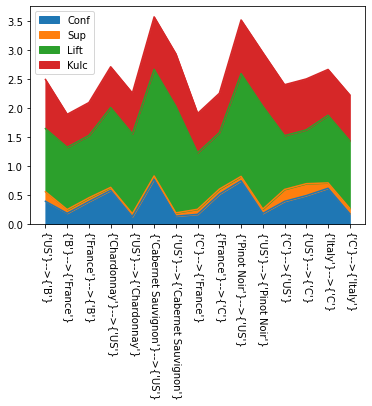

In [105]:
xticks = []
for item in RuleList[1:]:
    xticks.append(str(set(item[0]))+ "-->" + str(set(item[1])))
l = len(xticks)

df.plot.area()
plt.xticks(range(l),xticks)
plt.xticks(rotation=270)
plt.show()

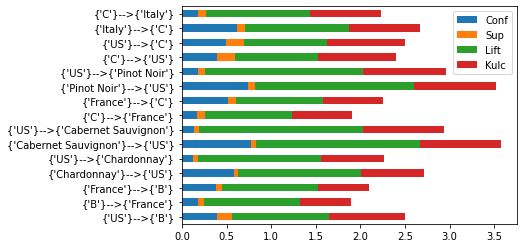

In [110]:
# 使用bar()生成直方图，barh()生成水平条形图（要生成一个堆积条形图，通过指定：pass stacked=True）
df.plot.barh(stacked=True)# 图3
plt.yticks(range(l),xticks)
plt.show()